In [23]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
from PIL import Image
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 11.8 ms


We read in the data and perform a simple train test split.

In [24]:
df = pd.read_csv('allwaldo64.csv') # read in the data

time: 28.4 s


In [25]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,waldo
0,224,225,230,222,247,229,121,50,76,66,...,168,222,237,216,232,216,253,237,169,1
1,205,216,240,250,244,240,241,236,232,216,...,154,85,0,2,28,93,58,4,62,1
2,247,249,249,246,247,248,249,247,250,158,...,32,65,170,229,192,151,162,198,226,1
3,38,34,34,36,31,21,14,13,3,9,...,185,115,255,243,255,236,250,245,253,1
4,255,255,255,231,184,168,176,178,157,140,...,142,169,121,117,119,145,176,175,195,1


time: 23 ms


In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)
X_train = train_set.drop('waldo',axis=1)
y_train = train_set['waldo']
X_test = test_set.drop('waldo',axis=1)
y_test = test_set['waldo']

time: 1.44 s


First, calculate the eigenvectors and eigenvalues of the covarience matrix.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0)
pca.fit(X_train);

time: 2min 2s


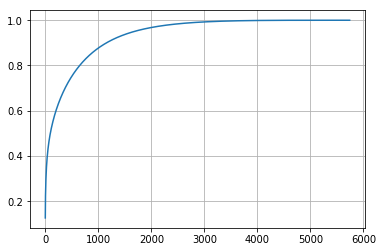

time: 247 ms


In [28]:
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(exp_var_cum.size), exp_var_cum)
plt.grid()

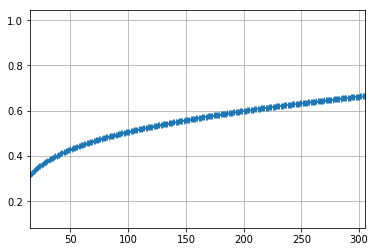

time: 179 ms


In [29]:
plt.plot(range(exp_var_cum.size), exp_var_cum, '-+')
plt.grid()
plt.xlim(15,305);

We seem to start getting severely diminishing returns after 200 components, so reducing the dimensionality to this degree won't lose much in explained variance. We now scale our data and perform dimensionality reduction using principal component analysis.

In [30]:
from sklearn.preprocessing import StandardScaler
X_std_train = StandardScaler().fit_transform(X_train)
X_std_test = StandardScaler().fit_transform(X_test)

pca = PCA(n_components=200, random_state=0)
pca.fit(X_std_train)
pca.fit(X_std_test)
X_train_pca = pca.transform(X_std_train)
X_test_pca = pca.transform(X_std_test)

time: 16.5 s


We now run a number of KNN models to determine the optimal fit on the data.

In [49]:
from sklearn.neighbors import KNeighborsClassifier
p=[]
temp = []
k=[]
for i in range(1,7):
    knn_pca = KNeighborsClassifier(n_neighbors=i,weights='uniform', n_jobs=-1)
    knn_pca.fit(X_train_pca, y_train)
    train_score_pca = knn_pca.score(X_train_pca, y_train)
    test_score_pca = knn_pca.score(X_test_pca, y_test)
    k.append(knn_pca)
    p.append(knn_pca.predict(X_test_pca))
    li = [i,train_score_pca,test_score_pca]
    temp.append(li)
temp

[[1, 1.0, 0.9310584958217271],
 [2, 0.985191637630662, 0.9338440111420613],
 [3, 0.9712543554006968, 0.9122562674094707],
 [4, 0.955226480836237, 0.9122562674094707],
 [5, 0.9503484320557491, 0.9073816155988857],
 [6, 0.927177700348432, 0.8857938718662952]]

time: 14.3 s


It looks like `k=2` gives us the best performance out of sample, ~93% accuracy.
Let's plot a simple confusion matrix.

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, p[1])

array([[1054,   25],
       [  70,  287]])

time: 7.28 ms


In [47]:
from sklearn.model_selection import cross_val_score
full_data = np.append(X_train_pca, X_test_pca,axis=0)
full_y = np.append(y_train, y_test)
cross_val_score(k[1], full_data, full_y, cv=5)

array([0.92479109, 0.94011142, 0.91916376, 0.92543554, 0.93165969])

time: 2.6 s


To get a visual idea of how well our model is working, we plot the images that our model classifies as Waldo.

In [50]:
tpreds = []
for i in range(len(p[1])):
    if p[1][i] == 1:
        tpreds.append(y_test.axes[0][i])

time: 15.9 ms


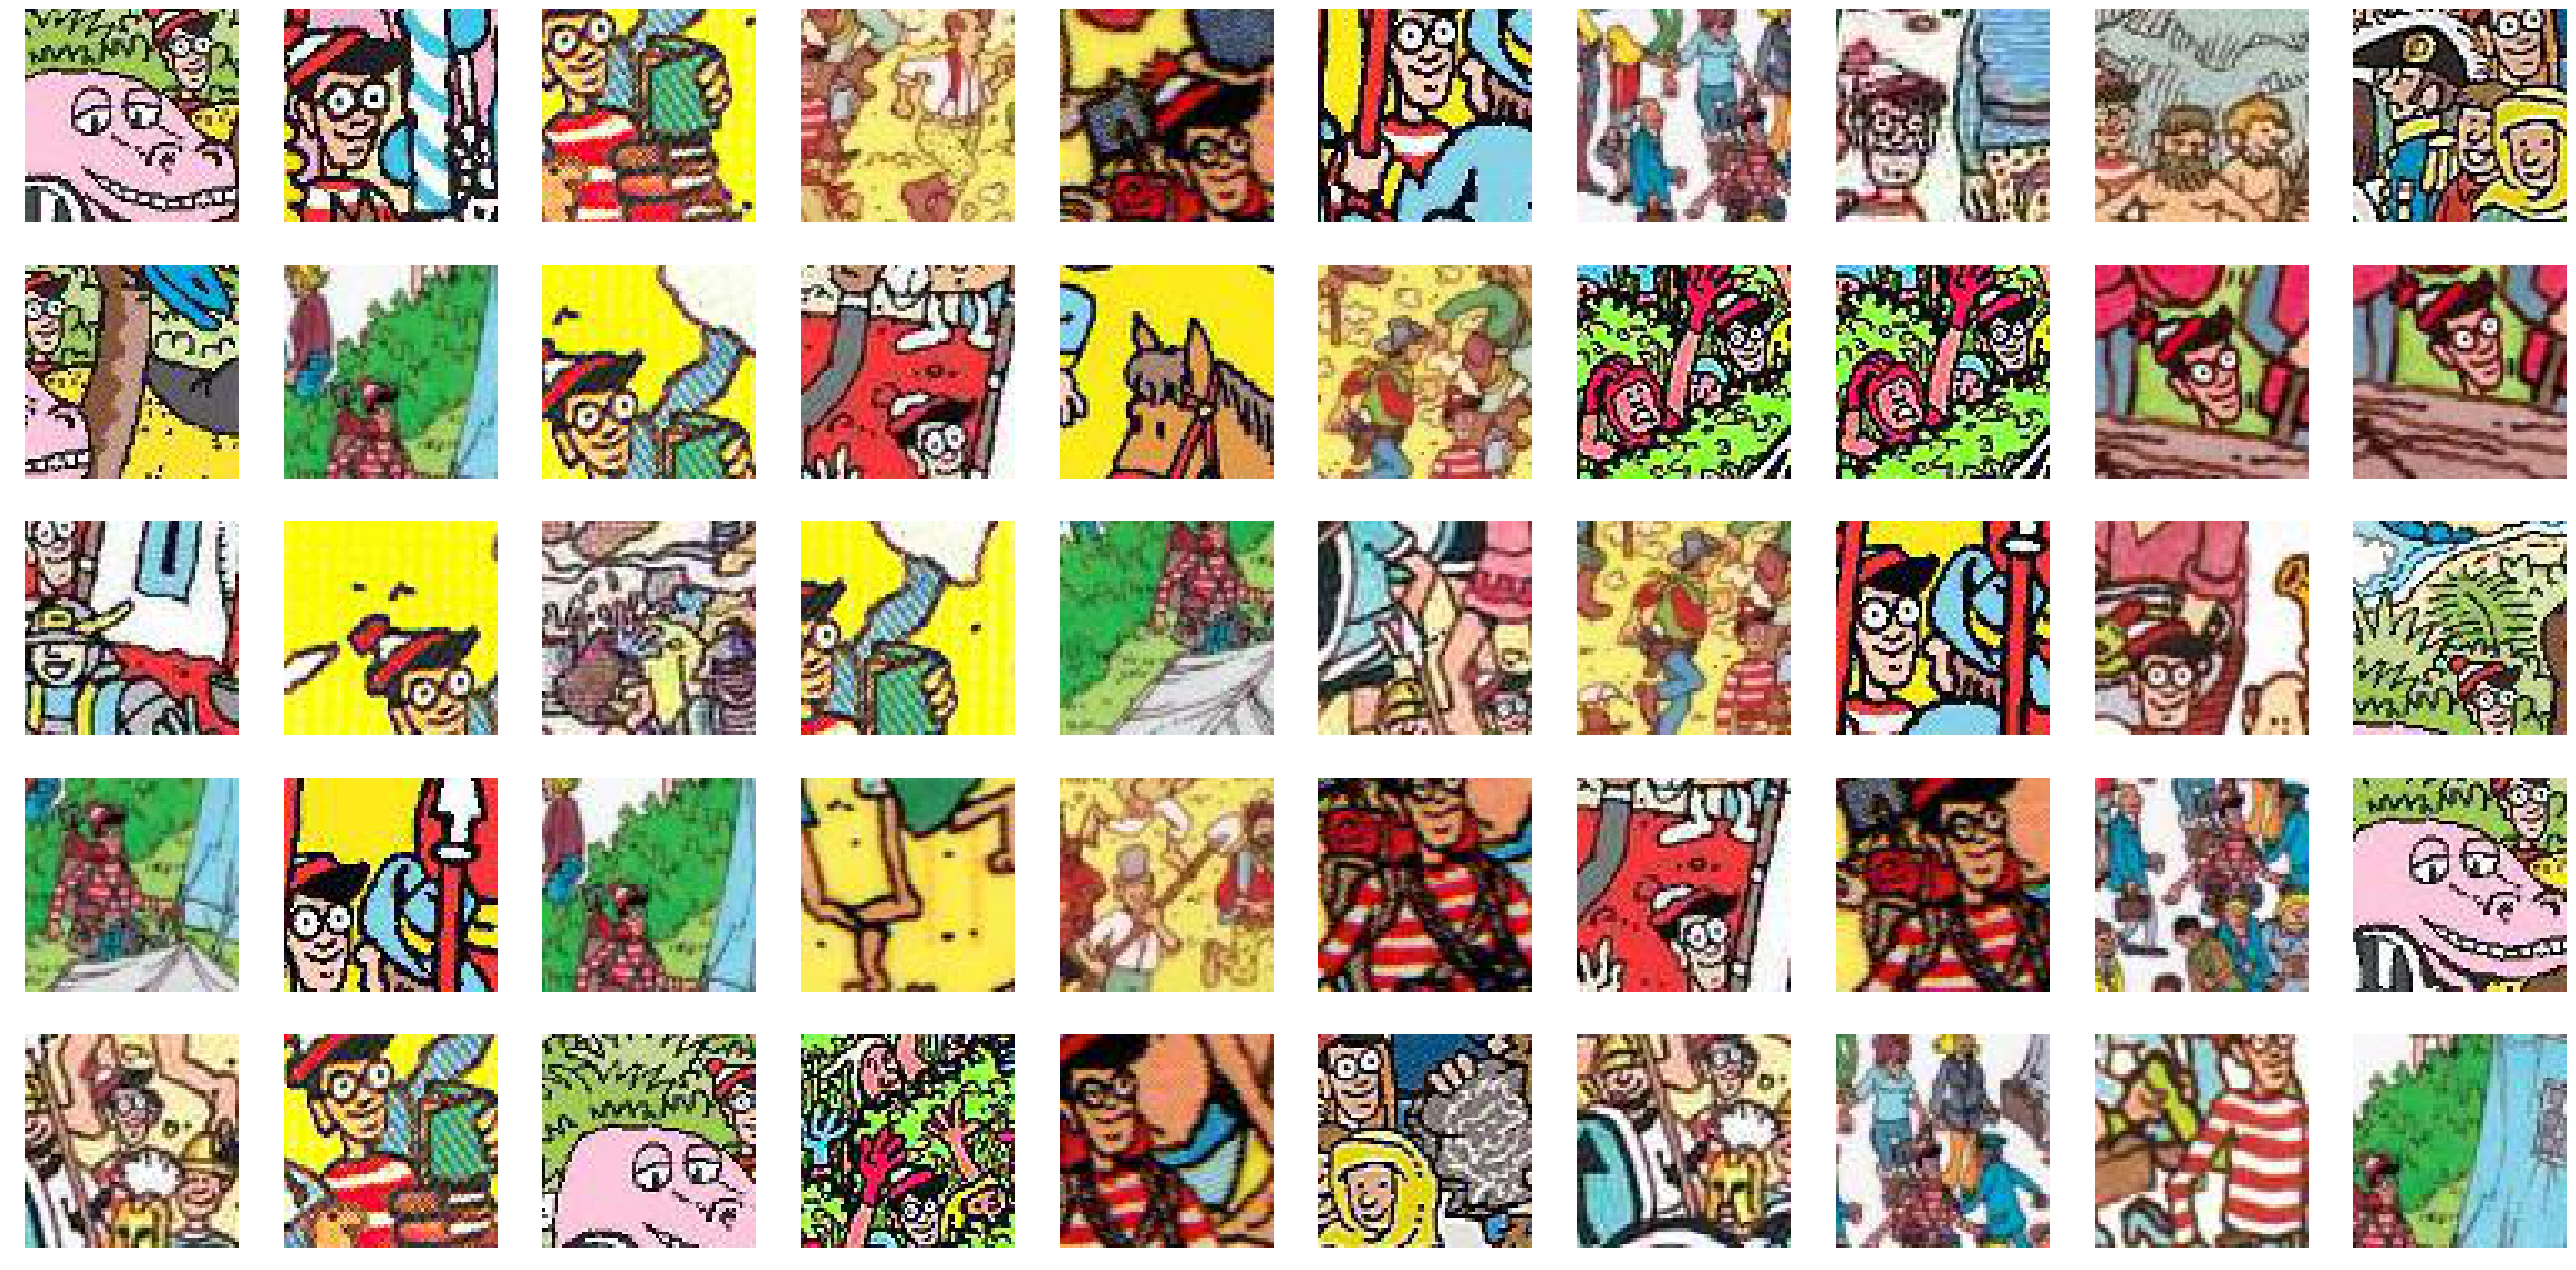

time: 7.01 s


In [51]:
plt.figure(figsize=(50,25))
for k in range(50):
    plt.subplot(5,10,k+1)
    plt.imshow(df.iloc[tpreds[k]].astype(np.uint8).drop('waldo').values.reshape(3, 64, 64).transpose().reshape(64,64, 3))
    plt.axis('off')

In this sample, we get 46/50 Waldos classified correctly. Not bad!

Let's plot the eigenvalues that our PCA is using to capture the variance.

In [35]:
eigenvalues = []
for k in range(pca.components_.shape[0]-1):
    p = pca.components_[k].reshape(3, 64, 64).transpose().reshape(64,64, 3)
    eigenvalues.append(p)

time: 58 ms


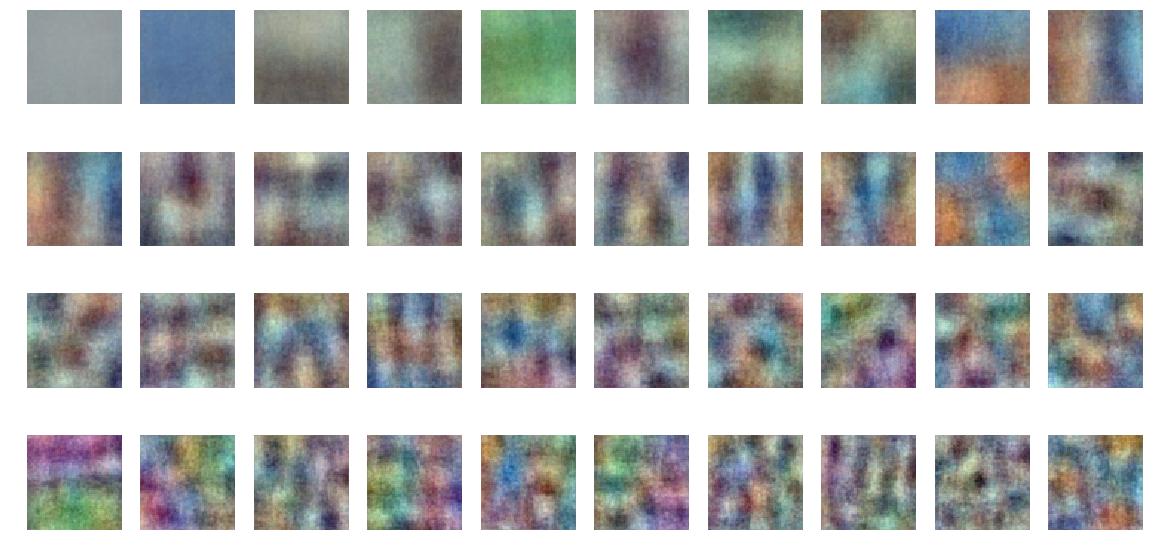

time: 2.92 s


In [36]:
scaled = (1/abs(2*np.min(pca.components_))) * pca.components_ + 0.5
plt.figure(figsize=(20,10))
for k in range(40):
    plt.subplot(4,10,k+1)
    plt.imshow(scaled[k].reshape(3, 64, 64).transpose().reshape(64,64,3), cmap='jet')
    plt.axis('off')